In [1]:
#Experiment1
#After deleting the useless data at the time of transmission, the data was put into a total Excel file and statistically analysed to find outliers in speed and distance
import pandas as pd
import numpy as np
import os

def cleanALL(file_path):
    # Define column names based on the observed structure
    column_names = ["Time", "ID", "Positionx","Positionz","Positiony", "Yaw", "Up", "Right", "Down", "Left"]

    # Read the CSV file without a header and assign column names
    data = pd.read_csv(file_path, header=None, names=column_names)

    # Correct the time
    initial_time = data.loc[0, 'Time']
    data['Time'] = data['Time'] - initial_time

    # Remove parentheses from the Positionx and Positiony columns
    data['Positionx'] = data['Positionx'].astype(str).str.replace('(', '').str.replace(')', '')
    data['Positiony'] = data['Positiony'].astype(str).str.replace('(', '').str.replace(')', '')
    data['Positiony'] = pd.to_numeric(data['Positiony'], errors='coerce')
    data['Positionx'] = pd.to_numeric(data['Positionx'], errors='coerce')
    
    # Calculate the distance from the origin (0, 0) for each row and create a new 'distance' column
    data['Distance'] = np.sqrt(data['Positionx']**2 + data['Positiony']**2)

    # Create an empty DataFrame to store the filtered results
    filtered_data = []
    # Loop through the Positiony column and filter rows that meet the conditions

    # Assign labels to each row based on the starting point of the transmission
    highlight_rows = []
    for i in range(len(data) - 1):
        if -1.5 < data.loc[i, 'Positiony'] and abs(data.loc[i, 'Distance'] - data.loc[i + 1, 'Distance']) > 5:
            highlight_rows.append(i)
            highlight_rows.append(i + 1)

    data['Label'] = 0
    current_label = 1
    if (highlight_rows):
        data.loc[:highlight_rows[0], 'Label'] = current_label
        for i in range(1, len(highlight_rows), 2):
            current_label += 1
            start_index = highlight_rows[i] + 1
            if i + 1 < len(highlight_rows):
                end_index = highlight_rows[i + 1]
                data.loc[start_index:end_index, 'Label'] = current_label
            else:
                data.loc[start_index:, 'Label'] = current_label

    for i in range(1, len(data)):
        if data.loc[i, 'Label'] == 0:
            data.loc[i, 'Label'] = data.loc[i + 1, 'Label']

    clear_rows = []
    for i in range(len(data) - 1):
        if -1.5 < data.loc[i, 'Positiony'] and abs(data.loc[i, 'Distance'] - data.loc[i + 1, 'Distance']) > 5:
            for j in range(max(0, i-4), i+1):
                clear_rows.append(j)

    columns_to_keep = ['Time', 'ID']
    for row_index in clear_rows:
        for col in data.columns:
            if col not in columns_to_keep:
                data.at[row_index, col] = np.nan  # Set the values of the cleared rows to NaN

    data['Speed'] = np.nan
    for i in range(1, len(data)):
        if pd.notna(data.at[i, 'Positionx']) and pd.notna(data.at[i, 'Positiony']) and \
           pd.notna(data.at[i-1, 'Positionx']) and pd.notna(data.at[i-1, 'Positiony']):
            dx = data.at[i, 'Positionx'] - data.at[i-1, 'Positionx']
            dy = data.at[i, 'Positiony'] - data.at[i-1, 'Positiony']
            distance = np.sqrt(dx**2 + dy**2)
            dt = data.at[i, 'Time'] - data.at[i-1, 'Time']
            if dt != 0:
                speed = distance / dt
                data.at[i, 'Speed'] = speed
    return data

# Process multiple CSV files
folder_path = '/Users/yangfanzhou/Desktop/1.8/Experiment 1 data'
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

def extract_id(file_name):
    return int(file_name.split('_')[1])

csv_files.sort(key=lambda x: extract_id(os.path.basename(x)))

all_data = pd.DataFrame()

for file_path in csv_files:
    try:
        processed_data = cleanALL(file_path)
        all_data = pd.concat([all_data, processed_data], ignore_index=True)
        print(f"Processed file: {file_path}")
    except Exception as e:
        print(f"Error in processing loop for file {file_path}: {e}")

# Save all the processed data into a single large .xlsx file
output_path = '/Users/yangfanzhou/Desktop/1.8/Experiment1_abnormalvalue.xlsx'
all_data.to_excel(output_path, index=False, na_rep='NaN')

print(f"All data has been saved to {output_path}")


Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_40_240425_143418.csv
Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_41_240425_144554.csv
Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_43_240425_143855.csv
Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_45_240425_145116.csv
Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_50_240425_143650.csv
Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_51_240425_143659.csv
Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_52_240425_144751.csv
Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_53_240425_153959.csv
Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerPositions_53_240425_152535.csv
Processed file: /Users/yangfanzhou/Desktop/code/Experiment 1 data/PlayerP

In [2]:
import pandas as pd
import np
import matplotlib.pyplot as plt

# Read the merged data
file_path = '/Users/yangfanzhou/Desktop/1.8/Experiment1_abnormalvalue.xlsx'
data = pd.read_excel(file_path)

# Ensure the Speed column is numeric and remove NaN values
data['Speed'] = pd.to_numeric(data['Speed'], errors='coerce')
speed_data = data['Speed'].dropna()
data['Distance'] = pd.to_numeric(data['Distance'], errors='coerce')
distance_data = data['Distance'].dropna()

# Calculate the 95% two-tailed data
speed_percentile_2_5 = np.percentile(speed_data, 2.5)
speed_percentile_97_5 = np.percentile(speed_data, 97.5)
distance_percentile_2_5 = np.percentile(distance_data, 2.5)
distance_percentile_97_5 = np.percentile(distance_data, 97.5)

# Print the 95% two-tailed values
print(f"speed 2.5% percentile value: {speed_percentile_2_5}")
print(f"speed 97.5% percentile value: {speed_percentile_97_5}")
print(f"distance 2.5% percentile value: {distance_percentile_2_5}")
print(f"distance 97.5% percentile value: {distance_percentile_97_5}")


speed 2.5% percentile value: 0.0
speed 97.5% percentile value: 2.345892387057535
distance 2.5% percentile value: 0.8793179174792243
distance 97.5% percentile value: 10.387727369093284


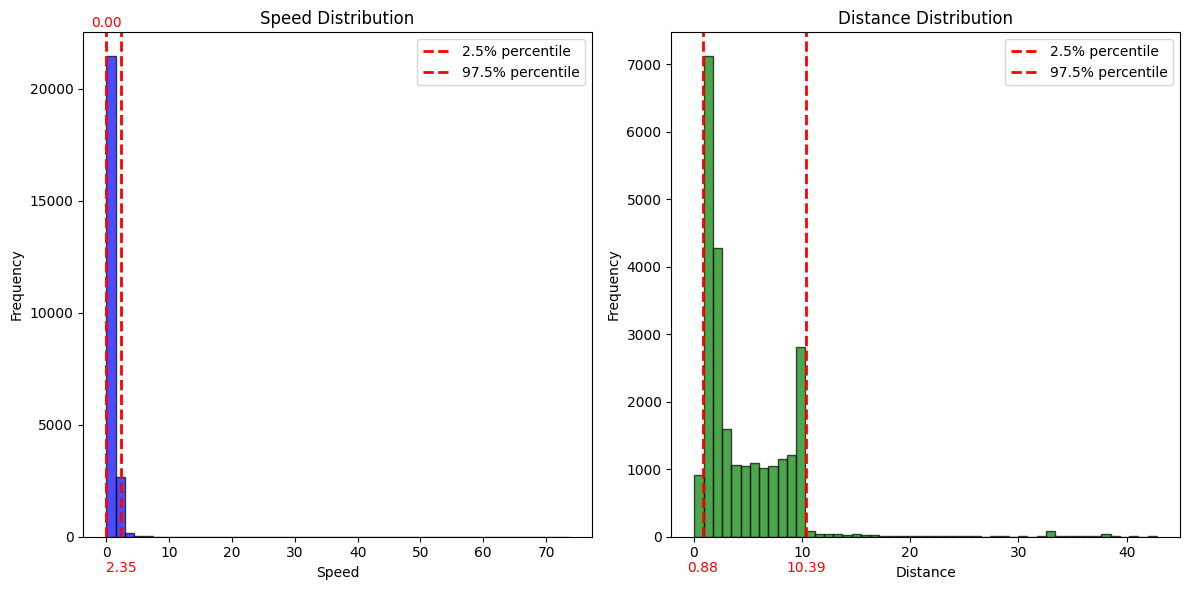

In [3]:
import matplotlib.pyplot as plt

# Plot speed distribution
plt.figure(figsize=(12, 6))

# Speed distribution
plt.subplot(1, 2, 1)
plt.hist(speed_data, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(speed_percentile_2_5, color='red', linestyle='dashed', linewidth=2)
plt.axvline(speed_percentile_97_5, color='red', linestyle='dashed', linewidth=2)
plt.text(speed_percentile_2_5, plt.ylim()[1]*1.01, f'{speed_percentile_2_5:.2f}', color='red', ha='center')
plt.text(speed_percentile_97_5, plt.ylim()[1]*-0.07, f'{speed_percentile_97_5:.2f}', color='red', ha='center')
plt.title('Speed Distribution')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.legend(['2.5% percentile', '97.5% percentile'])


# Distance distribution
plt.subplot(1, 2, 2)
plt.hist(distance_data, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.axvline(distance_percentile_2_5, color='red', linestyle='dashed', linewidth=2)
plt.axvline(distance_percentile_97_5, color='red', linestyle='dashed', linewidth=2)
plt.text(distance_percentile_2_5, plt.ylim()[1]*-0.07, f'{distance_percentile_2_5:.2f}', color='red', ha='center')
plt.text(distance_percentile_97_5, plt.ylim()[1]*-0.07, f'{distance_percentile_97_5:.2f}', color='red', ha='center')
plt.title('Distance Distribution')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend(['2.5% percentile', '97.5% percentile'])

plt.tight_layout()
plt.show()
